In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob

In [3]:
file_paths = sorted(glob.glob("csv_results/gender_sample_fraction_*.csv"))
all_dfs = []

for path in file_paths:
    df = pd.read_csv(path)
    df["sample_fraction"] = float(path.split("_")[-1].replace(".csv", ""))
    all_dfs.append(df)

# Объединяем в один DataFrame
df_all = pd.concat(all_dfs, ignore_index=True)

In [4]:
len(df_all)

2522

In [5]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

scaler = MinMaxScaler()

scaled = scaler.fit_transform(df_all[["metric_ripser_sum_H0", "metric_ripser_sum_H1"]])
weighted_sum = np.mean(scaled, axis=1)
df_all['ripser_weighted'] = weighted_sum

In [6]:
metric_columns = [col for col in df_all.columns if col.startswith("metric_")] + ['ripser_weighted']

corr_records = []

# Вычисляем корреляцию с accuracy для каждой метрики при каждом sample_fraction
for frac in sorted(df_all['sample_fraction'].unique()):
    sub = df_all[df_all['sample_fraction'] == frac]
    for metric in metric_columns:
        if sub[metric].nunique() > 1:  # нужно хотя бы 2 уникальных значения для корреляции
            corr = sub[metric].corr(sub['accuracy'])
            corr_records.append({
                "sample_fraction": frac,
                "metric": metric,
                "correlation": corr
            })

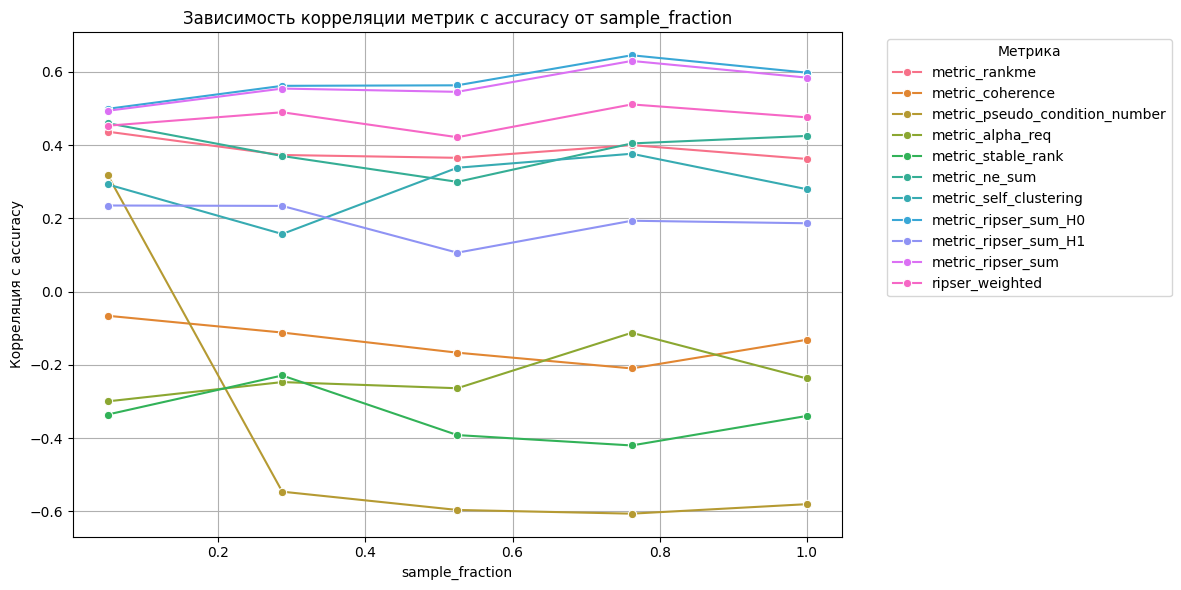

In [7]:
corr_df = pd.DataFrame(corr_records)

plt.figure(figsize=(12, 6))
sns.lineplot(data=corr_df, x="sample_fraction", y="correlation", hue="metric", marker="o")
plt.title("Зависимость корреляции метрик с accuracy от sample_fraction")
plt.xlabel("sample_fraction")
plt.ylabel("Корреляция с accuracy")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Метрика")
plt.tight_layout()
plt.show()

In [8]:
from scipy.stats import spearmanr


spear_corr_records = []

for frac in sorted(df_all['sample_fraction'].unique()):
    sub = df_all[df_all['sample_fraction'] == frac]
    for metric in metric_columns:
        if sub[metric].nunique() > 1 and sub['accuracy'].nunique() > 1:
            corr, _ = spearmanr(sub[metric], sub['accuracy'])
            spear_corr_records.append({
                "sample_fraction": frac,
                "metric": metric,
                "correlation": corr
            })
            


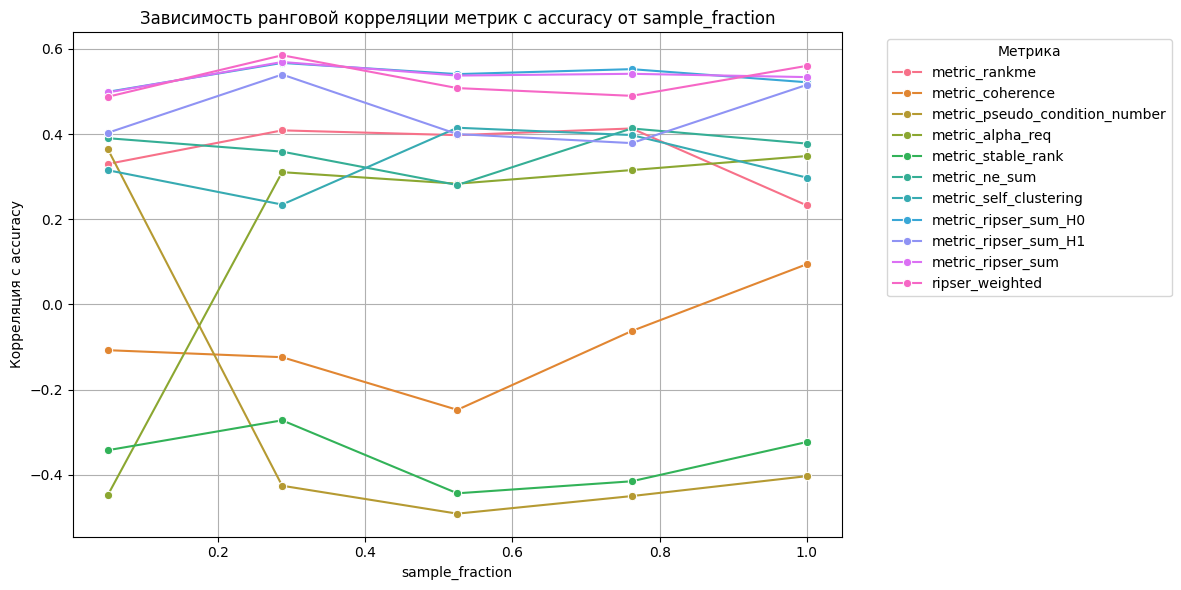

In [9]:
spear_corr_df = pd.DataFrame(spear_corr_records)

plt.figure(figsize=(12, 6))
sns.lineplot(data=spear_corr_df, x="sample_fraction", y="correlation", hue="metric", marker="o")
plt.title("Зависимость ранговой корреляции метрик с accuracy от sample_fraction")
plt.xlabel("sample_fraction")
plt.ylabel("Корреляция с accuracy")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Метрика")
plt.tight_layout()
plt.show()

In [11]:
mean_corr = spear_corr_df.groupby("metric")["correlation"].mean().sort_values(ascending=False)
mean_corr

metric
metric_ripser_sum_H0              0.536398
metric_ripser_sum                 0.536097
ripser_weighted                   0.526265
metric_ripser_sum_H1              0.447581
metric_ne_sum                     0.364211
metric_rankme                     0.356485
metric_self_clustering            0.332136
metric_alpha_req                  0.162117
metric_coherence                 -0.089272
metric_pseudo_condition_number   -0.280980
metric_stable_rank               -0.359171
Name: correlation, dtype: float64

/tmp/ipykernel_3643076/655376316.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=mean_corr.values, y=mean_corr.index, palette="viridis")
/tmp/ipykernel_3643076/655376316.py:7: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dpetrovitch/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


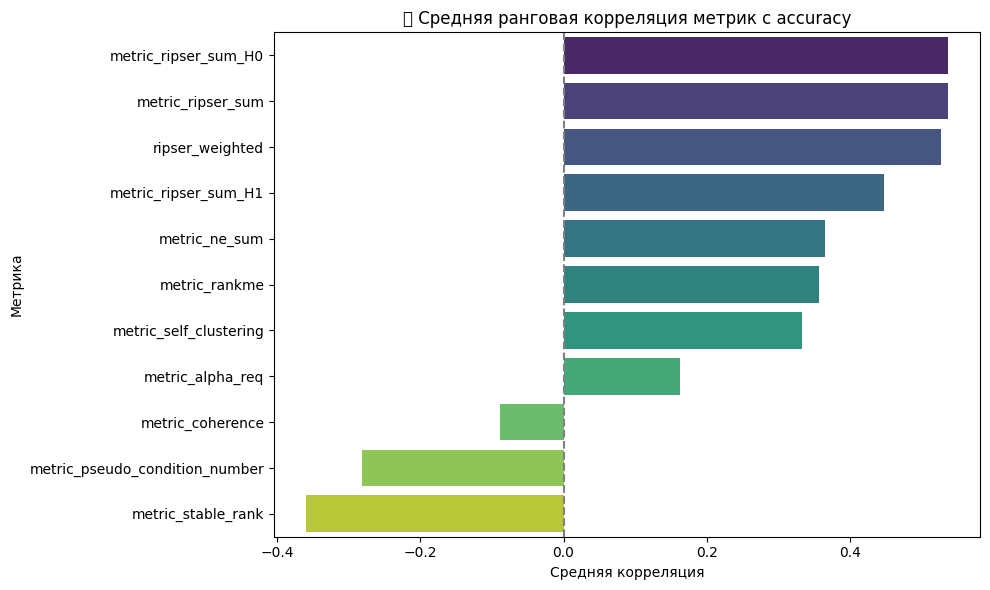

In [17]:
plt.figure(figsize=(10, 6))
sns.barplot(x=mean_corr.values, y=mean_corr.index, palette="viridis")
plt.title("📊 Средняя ранговая корреляция метрик с accuracy")
plt.xlabel("Средняя корреляция")
plt.ylabel("Метрика")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()

In [15]:
std_corr = spear_corr_df.groupby("metric")["correlation"].std().sort_values()

/tmp/ipykernel_3643076/2625709754.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sorted_std.values, y=sorted_std.index, palette="viridis")
/tmp/ipykernel_3643076/2625709754.py:10: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dpetrovitch/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


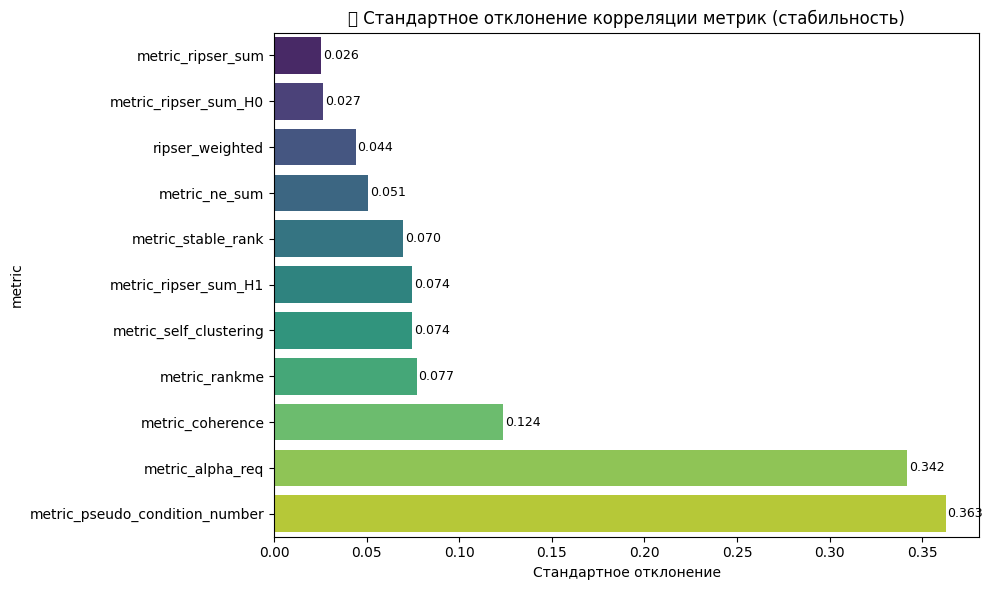

In [24]:
sorted_std = std_corr.sort_values(ascending=True)
plt.figure(figsize=(10, 6))
sns.barplot(x=sorted_std.values, y=sorted_std.index, palette="viridis")

for i, v in enumerate(sorted_std.values):
    plt.text(v + 0.001, i, f"{v:.3f}", color='black', ha='left', va='center', fontsize=9)

plt.title("📉 Стандартное отклонение корреляции метрик (стабильность)")
plt.xlabel("Стандартное отклонение")
plt.tight_layout()
plt.show()

/tmp/ipykernel_3643076/2211968343.py:5: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda df: spearmanr(df["sample_fraction"], df["correlation"]).correlation)
/tmp/ipykernel_3643076/2211968343.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=trend_corr.values, y=trend_corr.index, palette="magma")
/tmp/ipykernel_3643076/2211968343.py:15: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/dpetrovitch/venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: Use

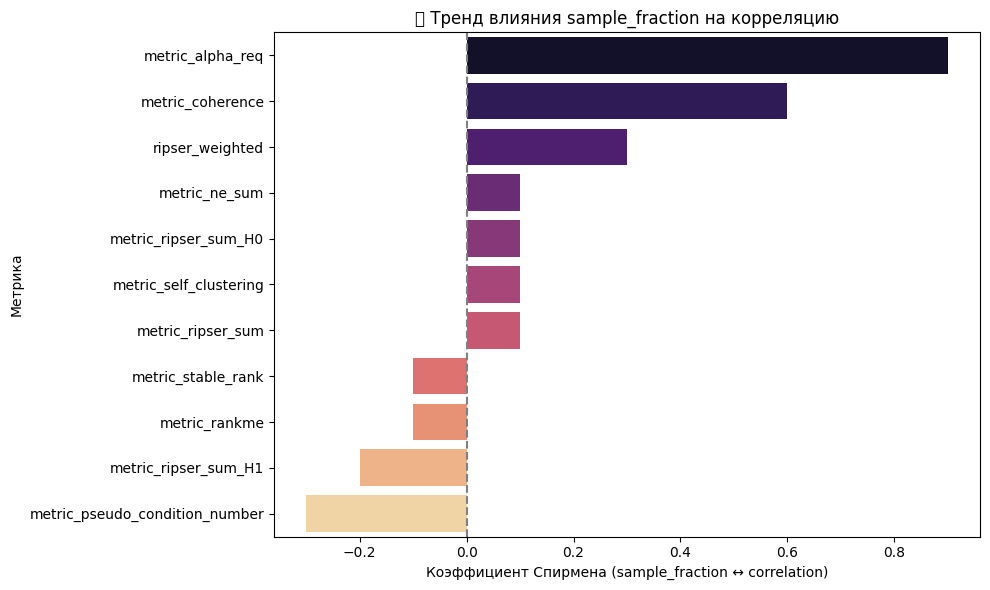

In [ ]:
from scipy.stats import spearmanr

trend_corr = (
    corr_df.groupby("metric")
    .apply(lambda df: spearmanr(df["sample_fraction"], df["correlation"]).correlation)
    .sort_values(ascending=False)
)

plt.figure(figsize=(10, 6))
sns.barplot(x=trend_corr.values, y=trend_corr.index, palette="magma")
plt.title("📈 Тренд влияния sample_fraction на корреляцию")
plt.xlabel("Коэффициент Спирмена (sample_fraction ↔ correlation)")
plt.ylabel("Метрика")
plt.axvline(0, color='gray', linestyle='--')
plt.tight_layout()
plt.show()


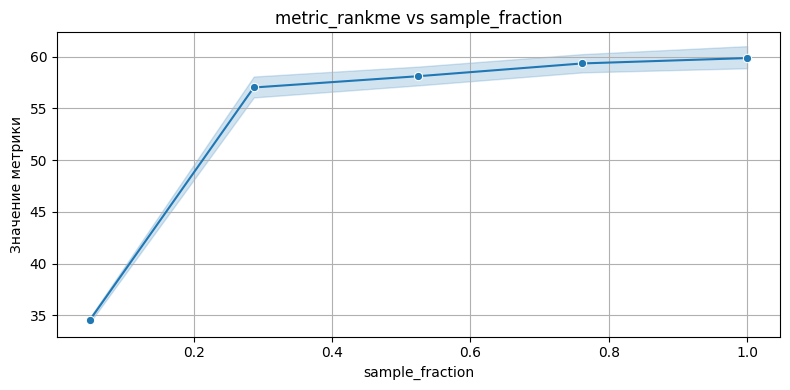

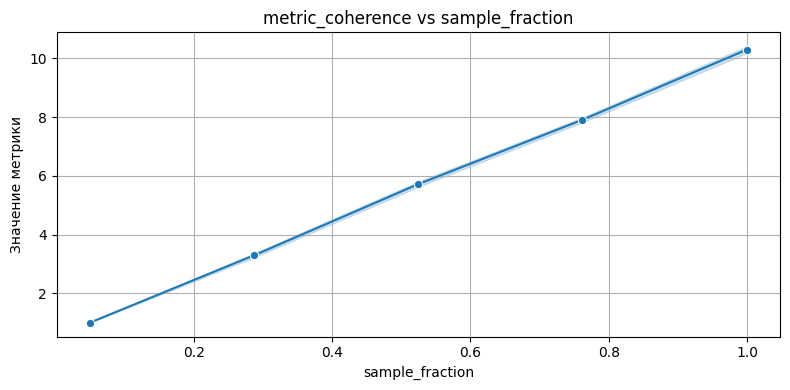

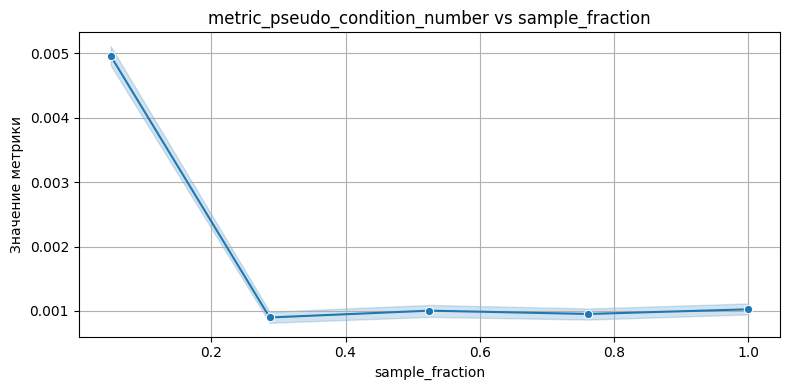

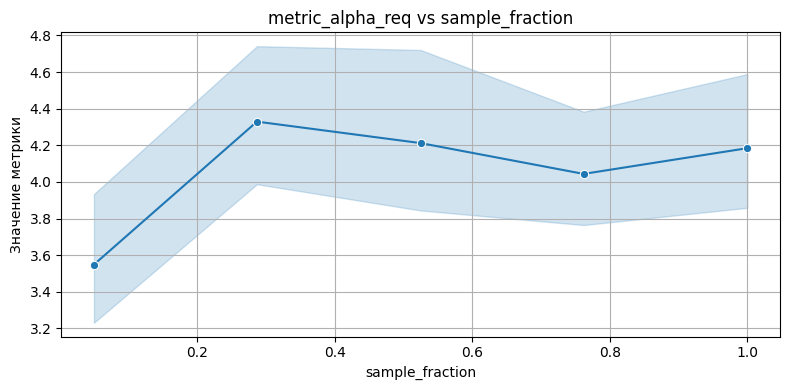

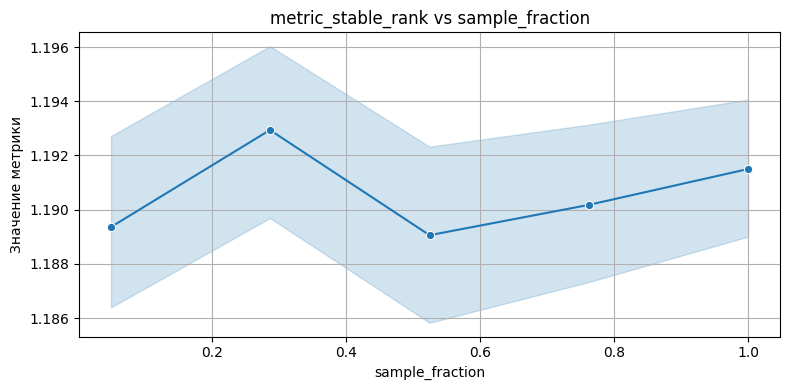

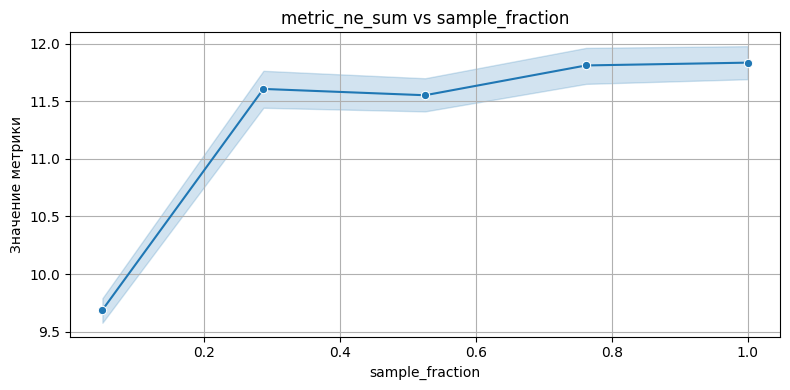

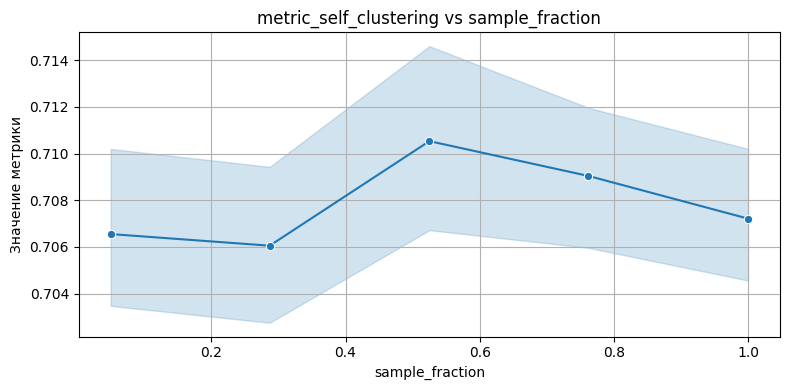

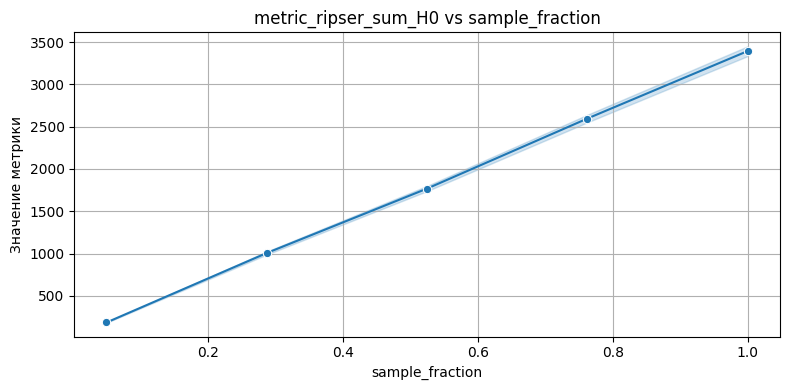

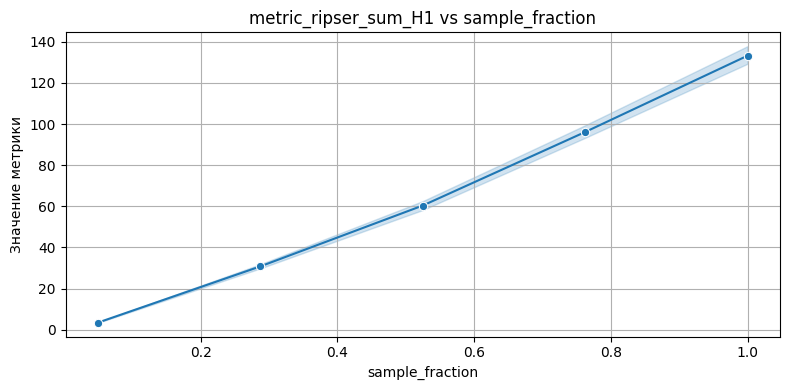

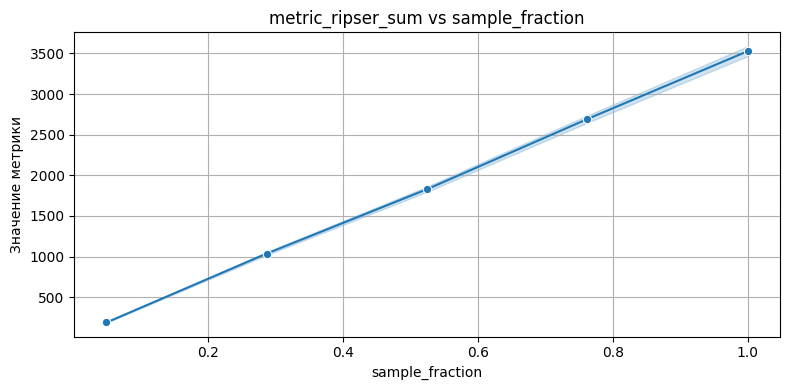

In [ ]:
for metric in metric_columns:
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=df_all, x="sample_fraction", y=metric, marker="o")
    plt.title(f"{metric} vs sample_fraction")
    plt.xlabel("sample_fraction")
    plt.ylabel("Значение метрики")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [1]:
from collections import defaultdict

def count_paths(start, end, allowed_ops):
    dp = defaultdict(int)
    dp[start] = 1

    for x in range(start, end + 1):
        if 'A' in allowed_ops and x + 3 <= end:
            dp[x + 3] += dp[x]
        if 'B' in allowed_ops and x * 4 <= end:
            dp[x * 4] += dp[x]
        if 'C' in allowed_ops and x * 5 <= end:
            dp[x * 5] += dp[x]
    return dp[end]

# 1 → 362: без B (только A и C)
paths_1_to_362 = count_paths(1, 362, allowed_ops={'A', 'C'})

# 362 → 725: все команды разрешены
paths_362_to_725 = count_paths(362, 725, allowed_ops={'A', 'B', 'C'})

# Общее число программ
total_programs = paths_1_to_362 * paths_362_to_725

print("Ответ:", total_programs)


Ответ: 58
